# Conway's Game Of Life

*This notebook originally appeared as a post on*
[*Pythonic Perambulations*](http://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/)
*by Jake Vanderplas.  The code and content is BSD-licensed.*

<!-- PELICAN_BEGIN_SUMMARY -->
In 1970 the British Mathematician John Conway created his "Game of Life" -- 
a set of rules that mimics the chaotic yet
patterned growth of a colony of biological organisms.  The "game" takes place on
a two-dimensional grid consisting of "living" and "dead" cells, and
the rules to step from generation to generation are simple:

- **Overpopulation:** if a living cell is surrounded by more than three living cells, it dies.
- **Stasis:** if a living cell is surrounded by two or three living cells, it survives.
- **Underpopulation:** if a living cell is surrounded by fewer than two living cells, it dies.
- **Reproduction:** if a dead cell is surrounded by exactly three cells, it becomes a live cell.

By enforcing these rules in sequential steps, beautiful and unexpected patterns can appear.

I was thinking about classic problems that could be used to demonstrate the effectiveness
of Python for computing and visualizing dynamic phenomena, and thought back to a high school
course I took where we had an assignment to implement a Game Of Life computation in C++.
If only I'd had access to IPython and associated tools back then, my homework assignment
would have been a whole lot easier!

Here I'll use Python and NumPy to compute generational steps for the game of life, and use
my [JSAnimation](http://github.com/jakevdp/JSAnimation) package to animate the results.
<!-- PELICAN_END_SUMMARY -->

Because the Game of Life is so simple, the time step can be computed rather
tersely in Python.  Here I implement two possibilities: one using generator expressions,
and one using the ``convolve2d`` function from ``scipy``.  Note that neither of
these are extremely performant: they involve creating several temporary arrays,
and will not work well for large problems with many time steps.  Nevertheless,
the simplicity makes these functions very attractive, and they are absolutely sufficient
for the small examples we'll consider here:

In [47]:
import numpy as np

def life_step_1(X):
    """Game of life step using generator expressions"""
    nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    #return (nbrs_count == 3) | (X & (nbrs_count == 2)) 
    return  (nbrs_count == 3) | (X & (nbrs_count == 2)) | (X & (nbrs_count == 4)) # Modified: cells with 2,3 or 4 neighbors live

def life_step_2(X):
    """Game of life step using scipy tools"""
    from scipy.signal import convolve2d
    nbrs_count = convolve2d(X, np.ones((3, 3)), mode='same', boundary='wrap') - X
    return (nbrs_count == 3) | (X & (nbrs_count == 2))
    
life_step = life_step_1

Note that we've made a choice here about the game boundary.  Classically, the
game takes place on an infinite, flat plane.  Here, for simplicity, we've used
a torroidal geometry (likely familiar to players of 1980s computer games like
Asteroids), where the grid wraps from top to bottom and left to right.

Now we'll use the matplotlib animation submodule to visualize the results
(for a tutorial on matplotlib animations, see my [previous post](http://jakevdp.github.io/)
on the subject).  We'll make use of my ``JSAnimation`` package, which you
can read about [here](http://jakevdp.github.io).

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [37]:
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
#from JSAnimation.IPython_display import display_animation, anim_to_html
from IPython.display import HTML
from matplotlib import animation

def life_animation(X, dpi=10, frames=10, interval=300, mode='loop'):
    """Produce a Game of Life Animation
    
    Parameters
    ----------
    X : array_like
        a two-dimensional numpy array showing the game board
    dpi : integer
        the number of dots per inch in the resulting animation.
        This controls the size of the game board on the screen
    frames : integer
        The number of frames to compute for the animation
    interval : float
        The time interval (in milliseconds) between frames
    mode : string
        The default mode of the animation.  Options are ['loop'|'once'|'reflect']
    """
    X = np.asarray(X)
    assert X.ndim == 2
    X = X.astype(bool)
    
    X_blank = np.zeros_like(X)
    #figsize = (X.shape[1] * 1. / dpi, X.shape[0] * 1. / dpi)
    
    # Hard code the figsize for now
    fig = plt.figure(figsize=(4,3), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap=plt.cm.binary, interpolation='nearest')
    im.set_clim(-0.05, 1)  # Make background gray

    # initialization function: plot the background of each frame
    def init():
        im.set_data(X_blank)
        return (im,)

    # animation function.  This is called sequentially
    def animate(i):
        im.set_data(animate.X)
        animate.X = life_step(animate.X)
        return (im,)
    animate.X = X

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=interval)
    
    #print anim_to_html(anim)
    return HTML(anim.to_jshtml())

Let's give this a try with a random starting field:

/Users/alpakpinar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


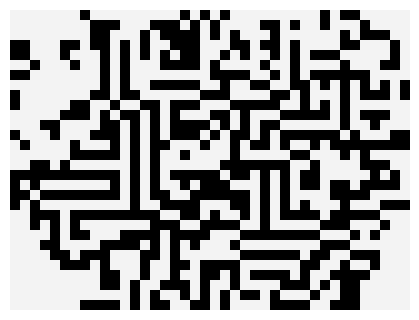

In [48]:
np.random.seed(0)
X = np.zeros((30, 40), dtype=bool)
r = np.random.random((10, 20))
X[10:20, 10:30] = (r > 0.75)
life_animation(X, dpi=100, frames=40, mode='once')

With the above random seed, the cells die off after about 40 generations.
In the process, some very interesting patterns show up: there are static
patterns, oscillating patterns, and a lot of spontaneous symmetry.  Let's
explore a few of the well-known patterns here:

## Static Configurations

Several static configurations are known: some of the smallest static units
are shown here.  We'll generate a few frames just to show that they are
in fact static.

/Users/alpakpinar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


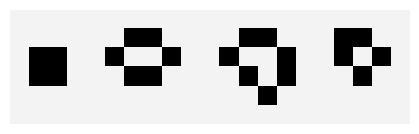

In [49]:
X = np.zeros((6, 21))
X[2:4, 1:3] = 1
X[1:4, 5:9] = [[0, 1, 1, 0],
               [1, 0, 0, 1],
               [0, 1, 1, 0]]
X[1:5, 11:15] = [[0, 1, 1, 0],
                 [1, 0, 0, 1],
                 [0, 1, 0, 1],
                 [0, 0, 1, 0]]
X[1:4, 17:20] = [[1, 1, 0],
                 [1, 0, 1],
                 [0, 1, 0]]

life_animation(X, dpi=100, frames=3)

## Some simple oscillators (The "Blinker" and the "Toad")

An oscillator is a pattern that returns to its initial configuration after some number
of steps.  The static patterns shown above could be thought of as oscillators with a
period of one.  Here are two commonly-seen period-two oscillators:

/Users/alpakpinar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


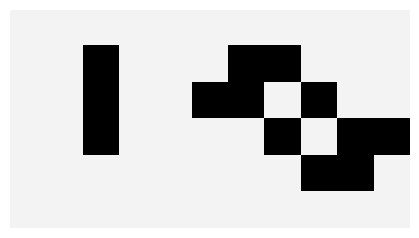

In [50]:
blinker = [1, 1, 1]
toad = [[1, 1, 1, 0],
        [0, 1, 1, 1]]

X = np.zeros((6, 11))
X[2, 1:4] = blinker
X[2:4, 6:10] = toad
life_animation(X, dpi=100, frames=4)

## Another Oscillator: The "Pulsar"

More complicated oscillators exist.  Here's a period-three oscillator known as
"The Pulsar", which displays some appealing symmetry.

/Users/alpakpinar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


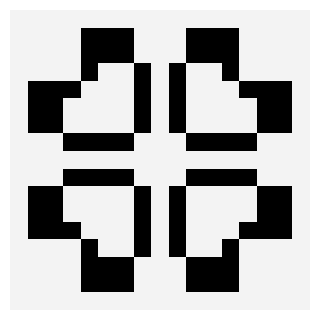

In [51]:
X = np.zeros((17, 17))
X[2, 4:7] = 1
X[4:7, 7] = 1
X += X.T
X += X[:, ::-1]
X += X[::-1, :]
life_animation(X, dpi=100, frames=6)

## The "Glider"

There are other classes of object which oscillate, but also move while oscillating.
One of the earliest seen is the "Glider", which after 4 steps returns to its
initial configuration, but shifted by one cell in both the x and y direction.
This is a configuration that often emerges from random starting points.

/Users/alpakpinar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


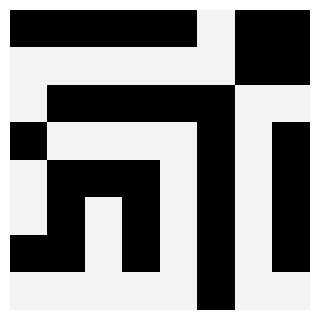

In [52]:
glider = [[1, 0, 0],
          [0, 1, 1],
          [1, 1, 0]]
X = np.zeros((8, 8))
X[:3, :3] = glider
life_animation(X, dpi=100, frames=32, interval=100)

## Unbounded Growth

An early question posed about the Game of Life was whether any configurations exist which
result in asymptotically unbounded growth.  It was quickly found that the answer was yes.  Though
it wasn't the first discovered, the following is one of the most compact configurations which
display unbounded growth.  Note that this claim is precisely true only on an infinite game
board: using a torroidal (i.e. wrapping) geometry like we do here will lead to different
results, but the first several hundred generations are unaffected:

/Users/alpakpinar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


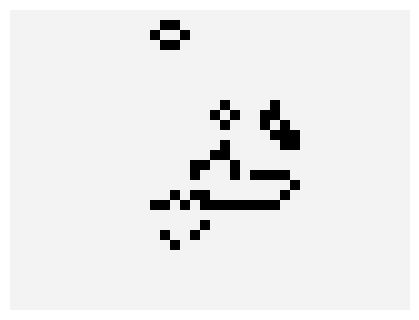

In [30]:
unbounded = [[1, 1, 1, 0, 1],
             [1, 0, 0, 0, 0],
             [0, 0, 0, 1, 1],
             [0, 1, 1, 0, 1],
             [1, 0, 1, 0, 1]]
X = np.zeros((30, 40))
X[15:20, 18:23] = unbounded
life_animation(X, dpi=100, frames=100, interval=200, mode='once')

## The "Gosper Glider Gun"

The earliest known instance of unbounded growth is one of my favorite configurations:
the "Glider Gun" discovered by Bill Gosper.  It is an oscillating pattern that creates
an infinite series of gliders.  It still amazes me that something like this can even
emerge from Conway's simple rules, but here it is.  We'll stop after a couple hundred
frames, but given an infinite game board this action would go on forever:

/Users/alpakpinar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


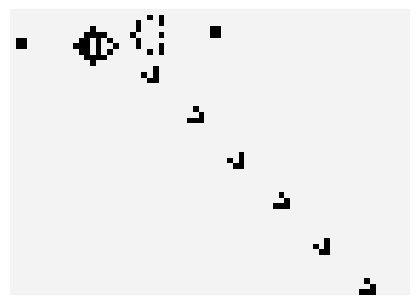

In [32]:
glider_gun =\
[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

X = np.zeros((50, 70))
X[1:10,1:37] = glider_gun

life_animation(X, dpi=100, frames=180, interval=50, mode='once')

## Going Further

Note that while the code above is well-suited for small explorations,
it is probably not sufficient to do very large and long game of life
computations.  For that, I'd recommend [Golly](http://golly.sourceforge.net/), an
open-source cross-platform package for computing and visualizing the Game of Life.
It has some nice optimizations, including a blazing fast hash-based computation of
generational steps for long-lived problems.

Diving further in, you might come across other very cool patterns.  One pattern, known as a "Breeder",
moves through space creating glider guns, which in turn create an endless series of
gliders.  Wikipedia has a [great animation](http://en.wikipedia.org/wiki/File:Conways_game_of_life_breeder_animation.gif)
of this in action:

<img src="http://upload.wikimedia.org/wikipedia/commons/e/e6/Conways_game_of_life_breeder_animation.gif">

Notice the series of glider guns, similar to the one we built above.
While this animation could certainly be created using the above Python code,
I'm just not sure I'd have the patience!


Despite (or perhaps because of) its simplicity, the Game of Life
has inspired an entire community of people who study its properties.  It has influenced fields
as diverse as mathematics, computer science, biology, epidemiology, and sociology.
This interest has led to the discovery of configurations with some very surprising properties.
Incredibly, it has even been shown that a Universal Turing Machine can be created within
the rules of the game of life.  That is, a computer which can compute game of life steps
could, in theory, use this process to compute just about anything!

Here are another few patterns you might try embedding in a game board, to see what will happen.

In [11]:
diehard = [[0, 0, 0, 0, 0, 0, 1, 0],
           [1, 1, 0, 0, 0, 0, 0, 0],
           [0, 1, 0, 0, 0, 1, 1, 1]]

boat = [[1, 1, 0],
        [1, 0, 1],
        [0, 1, 0]]

r_pentomino = [[0, 1, 1],
               [1, 1, 0],
               [0, 1, 0]]

beacon = [[0, 0, 1, 1],
          [0, 0, 1, 1],
          [1, 1, 0, 0],
          [1, 1, 0, 0]]

acorn = [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [1, 1, 0, 0, 1, 1, 1]]

spaceship = [[0, 0, 1, 1, 0],
             [1, 1, 0, 1, 1],
             [1, 1, 1, 1, 0],
             [0, 1, 1, 0, 0]]

block_switch_engine = [[0, 0, 0, 0, 0, 0, 1, 0],
                       [0, 0, 0, 0, 1, 0, 1, 1],
                       [0, 0, 0, 0, 1, 0, 1, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0, 0, 0],
                       [1, 0, 1, 0, 0, 0, 0, 0]]

I hope you enjoyed this quick exploration! 
For more information on the wealth of information about this
game, you can browse the discussions and forums at
[Conway's Game of Life](http://conwaylife.com/)

*This post was written in an IPython notebook, which can be downloaded*
[*here*](http://jakevdp.github.io/downloads/notebooks/GameOfLife.ipynb),
*or viewed statically*
[*here*](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/GameOfLife.ipynb).

/Users/alpakpinar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


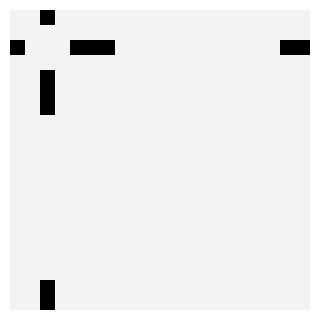

In [28]:
trial_1 = [[0,0,0,0,1,1,1,1],
           [1,1,1,1,0,0,0,0],
           [0,0,0,0,1,1,1,1],
           [1,1,1,1,0,0,0,0]]

trial_2 = [[1,0,1,0],
           [0,1,0,1],
           [1,0,1,0],
           [0,1,0,1]]

trial_3 = [[0,0,1,0,0,1,1,1],
           [1,1,0,1,1,0,0,0],
           [0,1,0,1,0,1,0,1],
           [1,0,1,0,1,0,1,0]]

trial_4 = [[1,1,1,1],
           [1,1,1,1],
           [1,1,1,1],
           [1,1,1,1]]

trial_5 = [[0,0,1,0,0],
           [0,1,0,1,0],
           [1,0,0,0,1],
           [0,1,0,1,0],
           [0,0,1,0,0]]

X = np.zeros((20,20))
#X[:4, :8] = trial_1
#X[:4,:4]=trial_4
X[:5,:5]=trial_5

life_animation(X, dpi=100, frames=20, interval=50, mode='once')

